In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.tensorboard.writer import SummaryWriter

from common import data
from common.training import get_predictions

from algos import stoc
from algos import cbl

from common.models import simple_conv
from common import metrics
from common.models.modutils import load_model


c:\Users\Zumo\anaconda3\envs\torch-gpu\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Zumo\anaconda3\envs\torch-gpu\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\Zumo\anaconda3\envs\torch-gpu\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
log_dir = "./final/stoc_wr"

horizon = 256
stride = 3 * (horizon // 4)

batch_size = 8

warm_restart = 1, 2
num_epochs = [2**i for i in range(7)]

out_feats = 64
k = 3
gamma = 0.05

learning_rate = 1e-2

weight_decay = 1e-1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [4]:
"""
../data/r216n09.gzip - 16388 timesteps - 3.76% anomalies - len seq anomal 4.9
../data/r229n10.gzip - 13239 timesteps - 4.21% anomalies - len seq anomal 4.6
../data/r233n14.gzip - 15384 timesteps - 3.66% anomalies - len seq anomal 4.8
../data/r245n15.gzip - 14874 timesteps - 4.04% anomalies - len seq anomal 4.7
"""
train = ["../data/r216n09.gzip", "../data/r245n15.gzip"]
test = ["../data/r233n14.gzip"]
m_data_train = data.Marconi100Dataset(train, scaling=data.Scaling.STANDARD)
m_data_test = data.Marconi100Dataset(test, scaling=data.Scaling.STANDARD)


Loading: 100%|██████████| 1/1 [00:04<00:00,  4.42s/it]


In [5]:
train_dataset = data.UnfoldedDataset(m_data_train, horizon=horizon, stride=stride)
test_dataset = data.UnfoldedDataset(m_data_test, horizon=horizon, stride=stride)

print(len(train_dataset), len(test_dataset))

164 80


In [6]:
base_width = 128
down_layers = 3
dilations = [False, True, True]

backbone = simple_conv.Encoder(data.NUM_FEATURES, down_layers, base_width, dilations)
model = simple_conv.SimpleConv(backbone, out_feats, horizon)

optim = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
lr_sched = CosineAnnealingWarmRestarts(optim, sum(num_epochs) // warm_restart[0], warm_restart[1])

aug = cbl.pipeline(
    cbl.random_apply(cbl.left_to_right_flipping(1), 0.5),
    cbl.random_apply(cbl.crop_and_resize(1.5, 3), 0.8),
)

engine = cbl.CBLEngine(
    model=model,
    optimizer=optim,
    temperature=0.5,
    aug_1=aug,
    aug_2=aug,
    lr_scheduler=lr_sched,
    device=device,
)

stoc_engine = stoc.STOC(engine, gamma)


In [9]:
with SummaryWriter(log_dir + "/logs") as writer:
    stoc_engine.fit(
        train_dataset,
        test_dataset,
        batch_size,
        k,
        num_epochs,
        writer=writer,
        save_path=log_dir + "/models",
    )


# stoc_engine.fit(train_dataset, test_dataset, batch_size, k, num_epochs)

Iteration 0 - Epoch 0 - train_loss=1.654 - test_loss=2.634 - lr=1.00e-02


Iteration 1 - Epoch 0 - train_loss=1.596 - test_loss=2.395 - lr=1.00e-02


Iteration 1 - Epoch 1 - train_loss=1.519 - test_loss=2.519 - lr=9.99e-03


Iteration 2 - Epoch 0 - train_loss=1.621 - test_loss=2.365 - lr=9.99e-03


Iteration 2 - Epoch 1 - train_loss=1.606 - test_loss=2.269 - lr=9.98e-03


Iteration 2 - Epoch 2 - train_loss=1.515 - test_loss=2.389 - lr=9.96e-03


Iteration 2 - Epoch 3 - train_loss=1.560 - test_loss=2.440 - lr=9.95e-03


Iteration 3 - Epoch 0 - train_loss=1.525 - test_loss=2.369 - lr=9.93e-03


Iteration 3 - Epoch 1 - train_loss=1.445 - test_loss=2.550 - lr=9.90e-03


Iteration 3 - Epoch 2 - train_loss=1.513 - test_loss=2.429 - lr=9.88e-03


Iteration 3 - Epoch 3 - train_loss=1.394 - test_loss=2.414 - lr=9.85e-03


Iteration 3 - Epoch 4 - train_loss=1.360 - test_loss=2.447 - lr=9.82e-03


Iteration 3 - Epoch 5 - train_loss=1.309 - test_loss=2.457 - lr=9.78e-03


Iteration 3 - Epoch 6 - train_loss=1.333 - test_loss=2.427 - lr=9.74e-03


Iteration 3 - Epoch 7 - train_loss=1.300 - test_loss=2.415 - lr=9.70e-03


Iteration 4 - Epoch 0 - train_loss=1.329 - test_loss=2.331 - lr=9.66e-03


Iteration 4 - Epoch 1 - train_loss=1.214 - test_loss=2.393 - lr=9.61e-03


Iteration 4 - Epoch 2 - train_loss=1.147 - test_loss=2.364 - lr=9.56e-03


Iteration 4 - Epoch 3 - train_loss=1.248 - test_loss=2.368 - lr=9.51e-03


Iteration 4 - Epoch 4 - train_loss=1.242 - test_loss=2.433 - lr=9.46e-03


Iteration 4 - Epoch 5 - train_loss=1.201 - test_loss=2.423 - lr=9.40e-03


Iteration 4 - Epoch 6 - train_loss=1.385 - test_loss=2.366 - lr=9.34e-03


Iteration 4 - Epoch 7 - train_loss=1.162 - test_loss=2.333 - lr=9.28e-03


Iteration 4 - Epoch 8 - train_loss=1.206 - test_loss=2.188 - lr=9.21e-03


Iteration 4 - Epoch 9 - train_loss=1.218 - test_loss=2.468 - lr=9.14e-03


Iteration 4 - Epoch 10 - train_loss=1.292 - test_loss=2.429 - lr=9.07e-03


Iteration 4 - Epoch 11 - train_loss=1.306 - test_loss=2.381 - lr=9.00e-03


Iteration 4 - Epoch 12 - train_loss=1.319 - test_loss=2.417 - lr=8.93e-03


Iteration 4 - Epoch 13 - train_loss=1.329 - test_loss=2.296 - lr=8.85e-03


Iteration 4 - Epoch 14 - train_loss=1.218 - test_loss=2.326 - lr=8.77e-03


Iteration 4 - Epoch 15 - train_loss=1.277 - test_loss=2.396 - lr=8.69e-03


Iteration 5 - Epoch 0 - train_loss=1.205 - test_loss=2.373 - lr=8.60e-03


Iteration 5 - Epoch 1 - train_loss=1.214 - test_loss=2.435 - lr=8.51e-03


Iteration 5 - Epoch 2 - train_loss=1.125 - test_loss=2.370 - lr=8.42e-03


Iteration 5 - Epoch 3 - train_loss=1.135 - test_loss=2.463 - lr=8.33e-03


Iteration 5 - Epoch 4 - train_loss=1.211 - test_loss=2.430 - lr=8.24e-03


Iteration 5 - Epoch 5 - train_loss=1.238 - test_loss=2.367 - lr=8.14e-03


Iteration 5 - Epoch 6 - train_loss=1.123 - test_loss=2.362 - lr=8.05e-03


Iteration 5 - Epoch 7 - train_loss=1.201 - test_loss=2.406 - lr=7.95e-03


Iteration 5 - Epoch 8 - train_loss=1.171 - test_loss=2.356 - lr=7.85e-03


Iteration 5 - Epoch 9 - train_loss=1.263 - test_loss=2.378 - lr=7.75e-03


Iteration 5 - Epoch 10 - train_loss=1.089 - test_loss=2.379 - lr=7.64e-03


Iteration 5 - Epoch 11 - train_loss=1.111 - test_loss=2.389 - lr=7.54e-03


Iteration 5 - Epoch 12 - train_loss=1.064 - test_loss=2.398 - lr=7.43e-03


Iteration 5 - Epoch 13 - train_loss=1.118 - test_loss=2.401 - lr=7.32e-03


Iteration 5 - Epoch 14 - train_loss=1.155 - test_loss=2.356 - lr=7.21e-03


Iteration 5 - Epoch 15 - train_loss=1.132 - test_loss=2.362 - lr=7.10e-03


Iteration 5 - Epoch 16 - train_loss=1.169 - test_loss=2.401 - lr=6.98e-03


Iteration 5 - Epoch 17 - train_loss=1.211 - test_loss=2.430 - lr=6.87e-03


Iteration 5 - Epoch 18 - train_loss=1.135 - test_loss=2.399 - lr=6.76e-03


Iteration 5 - Epoch 19 - train_loss=1.055 - test_loss=2.380 - lr=6.64e-03


Iteration 5 - Epoch 20 - train_loss=1.099 - test_loss=2.445 - lr=6.52e-03


Iteration 5 - Epoch 21 - train_loss=1.084 - test_loss=2.409 - lr=6.40e-03


Iteration 5 - Epoch 22 - train_loss=1.149 - test_loss=2.436 - lr=6.28e-03


Iteration 5 - Epoch 23 - train_loss=1.057 - test_loss=2.385 - lr=6.16e-03


Iteration 5 - Epoch 24 - train_loss=1.047 - test_loss=2.432 - lr=6.04e-03


Iteration 5 - Epoch 25 - train_loss=1.094 - test_loss=2.446 - lr=5.92e-03


Iteration 5 - Epoch 26 - train_loss=1.051 - test_loss=2.397 - lr=5.80e-03


Iteration 5 - Epoch 27 - train_loss=1.034 - test_loss=2.421 - lr=5.68e-03


Iteration 5 - Epoch 28 - train_loss=1.023 - test_loss=2.383 - lr=5.56e-03


Iteration 5 - Epoch 29 - train_loss=0.998 - test_loss=2.328 - lr=5.43e-03


Iteration 5 - Epoch 30 - train_loss=1.077 - test_loss=2.483 - lr=5.31e-03


Iteration 5 - Epoch 31 - train_loss=1.228 - test_loss=2.425 - lr=5.19e-03


Iteration 6 - Epoch 0 - train_loss=1.258 - test_loss=2.379 - lr=5.06e-03


Iteration 6 - Epoch 1 - train_loss=1.175 - test_loss=2.394 - lr=4.94e-03


Iteration 6 - Epoch 2 - train_loss=1.248 - test_loss=2.357 - lr=4.81e-03


Iteration 6 - Epoch 3 - train_loss=1.269 - test_loss=2.380 - lr=4.69e-03


Iteration 6 - Epoch 4 - train_loss=1.225 - test_loss=2.340 - lr=4.57e-03


Iteration 6 - Epoch 5 - train_loss=1.232 - test_loss=2.403 - lr=4.44e-03


Iteration 6 - Epoch 6 - train_loss=1.200 - test_loss=2.417 - lr=4.32e-03


Iteration 6 - Epoch 7 - train_loss=1.155 - test_loss=2.386 - lr=4.20e-03


Iteration 6 - Epoch 8 - train_loss=1.228 - test_loss=2.422 - lr=4.08e-03


Iteration 6 - Epoch 9 - train_loss=1.161 - test_loss=2.374 - lr=3.96e-03


Iteration 6 - Epoch 10 - train_loss=1.185 - test_loss=2.348 - lr=3.84e-03


Iteration 6 - Epoch 11 - train_loss=1.095 - test_loss=2.384 - lr=3.72e-03


Iteration 6 - Epoch 12 - train_loss=1.202 - test_loss=2.415 - lr=3.60e-03


Iteration 6 - Epoch 13 - train_loss=1.260 - test_loss=2.419 - lr=3.48e-03


Iteration 6 - Epoch 14 - train_loss=1.232 - test_loss=2.453 - lr=3.36e-03


Iteration 6 - Epoch 15 - train_loss=1.179 - test_loss=2.384 - lr=3.24e-03


Iteration 6 - Epoch 16 - train_loss=1.169 - test_loss=2.416 - lr=3.13e-03


Iteration 6 - Epoch 17 - train_loss=1.192 - test_loss=2.401 - lr=3.02e-03


Iteration 6 - Epoch 18 - train_loss=1.241 - test_loss=2.394 - lr=2.90e-03


Iteration 6 - Epoch 19 - train_loss=1.153 - test_loss=2.326 - lr=2.79e-03


Iteration 6 - Epoch 20 - train_loss=1.144 - test_loss=2.357 - lr=2.68e-03


Iteration 6 - Epoch 21 - train_loss=1.162 - test_loss=2.411 - lr=2.57e-03


Iteration 6 - Epoch 22 - train_loss=1.105 - test_loss=2.436 - lr=2.46e-03


Iteration 6 - Epoch 23 - train_loss=1.197 - test_loss=2.443 - lr=2.36e-03


Iteration 6 - Epoch 24 - train_loss=1.128 - test_loss=2.436 - lr=2.25e-03


Iteration 6 - Epoch 25 - train_loss=1.146 - test_loss=2.447 - lr=2.15e-03


Iteration 6 - Epoch 26 - train_loss=1.099 - test_loss=2.418 - lr=2.05e-03


Iteration 6 - Epoch 27 - train_loss=1.144 - test_loss=2.390 - lr=1.95e-03


Iteration 6 - Epoch 28 - train_loss=1.156 - test_loss=2.369 - lr=1.86e-03


Iteration 6 - Epoch 29 - train_loss=1.123 - test_loss=2.381 - lr=1.76e-03


Iteration 6 - Epoch 30 - train_loss=1.125 - test_loss=2.382 - lr=1.67e-03


Iteration 6 - Epoch 31 - train_loss=1.141 - test_loss=2.425 - lr=1.58e-03


Iteration 6 - Epoch 32 - train_loss=1.175 - test_loss=2.437 - lr=1.49e-03


Iteration 6 - Epoch 33 - train_loss=1.146 - test_loss=2.437 - lr=1.40e-03


Iteration 6 - Epoch 34 - train_loss=1.244 - test_loss=2.430 - lr=1.31e-03


Iteration 6 - Epoch 35 - train_loss=1.092 - test_loss=2.406 - lr=1.23e-03


Iteration 6 - Epoch 36 - train_loss=1.131 - test_loss=2.375 - lr=1.15e-03


Iteration 6 - Epoch 37 - train_loss=1.099 - test_loss=2.377 - lr=1.07e-03


Iteration 6 - Epoch 38 - train_loss=1.081 - test_loss=2.415 - lr=9.99e-04


Iteration 6 - Epoch 39 - train_loss=1.190 - test_loss=2.408 - lr=9.26e-04


Iteration 6 - Epoch 40 - train_loss=1.134 - test_loss=2.412 - lr=8.56e-04


Iteration 6 - Epoch 41 - train_loss=1.191 - test_loss=2.396 - lr=7.88e-04


Iteration 6 - Epoch 42 - train_loss=1.106 - test_loss=2.412 - lr=7.22e-04


Iteration 6 - Epoch 43 - train_loss=1.114 - test_loss=2.418 - lr=6.60e-04


Iteration 6 - Epoch 44 - train_loss=1.114 - test_loss=2.394 - lr=6.00e-04


Iteration 6 - Epoch 45 - train_loss=1.125 - test_loss=2.441 - lr=5.42e-04


Iteration 6 - Epoch 46 - train_loss=1.093 - test_loss=2.419 - lr=4.88e-04


Iteration 6 - Epoch 47 - train_loss=1.165 - test_loss=2.423 - lr=4.36e-04


Iteration 6 - Epoch 48 - train_loss=1.059 - test_loss=2.424 - lr=3.87e-04


Iteration 6 - Epoch 49 - train_loss=1.051 - test_loss=2.390 - lr=3.40e-04


Iteration 6 - Epoch 50 - train_loss=1.066 - test_loss=2.371 - lr=2.97e-04


Iteration 6 - Epoch 51 - train_loss=1.105 - test_loss=2.362 - lr=2.56e-04


Iteration 6 - Epoch 52 - train_loss=1.177 - test_loss=2.415 - lr=2.19e-04


Iteration 6 - Epoch 53 - train_loss=1.110 - test_loss=2.366 - lr=1.84e-04


Iteration 6 - Epoch 54 - train_loss=1.192 - test_loss=2.428 - lr=1.52e-04


Iteration 6 - Epoch 55 - train_loss=1.080 - test_loss=2.418 - lr=1.23e-04


Iteration 6 - Epoch 56 - train_loss=1.102 - test_loss=2.423 - lr=9.76e-05


Iteration 6 - Epoch 57 - train_loss=1.057 - test_loss=2.444 - lr=7.48e-05


Iteration 6 - Epoch 58 - train_loss=1.078 - test_loss=2.418 - lr=5.50e-05


Iteration 6 - Epoch 59 - train_loss=1.083 - test_loss=2.379 - lr=3.82e-05


Iteration 6 - Epoch 60 - train_loss=1.051 - test_loss=2.404 - lr=2.45e-05


Iteration 6 - Epoch 61 - train_loss=1.105 - test_loss=2.415 - lr=1.38e-05


Iteration 6 - Epoch 62 - train_loss=1.102 - test_loss=2.439 - lr=6.12e-06


Iteration 6 - Epoch 63 - train_loss=1.076 - test_loss=2.407 - lr=1.53e-06


In [19]:
cmodel = metrics.default_cmodel()


In [11]:
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)
scores, labels = get_predictions(stoc_engine.predict, test_loader)


100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


In [20]:
cmodel.fit(scores, labels).optimize()


(-52.535591125489645, 0.19018555)

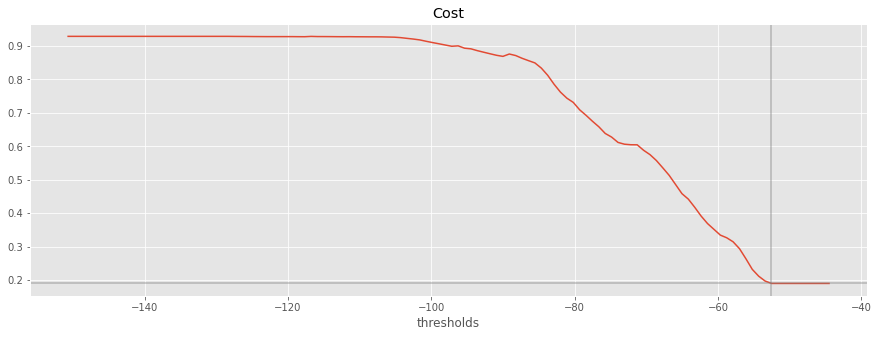

In [21]:
metrics.plot_cost(cmodel)


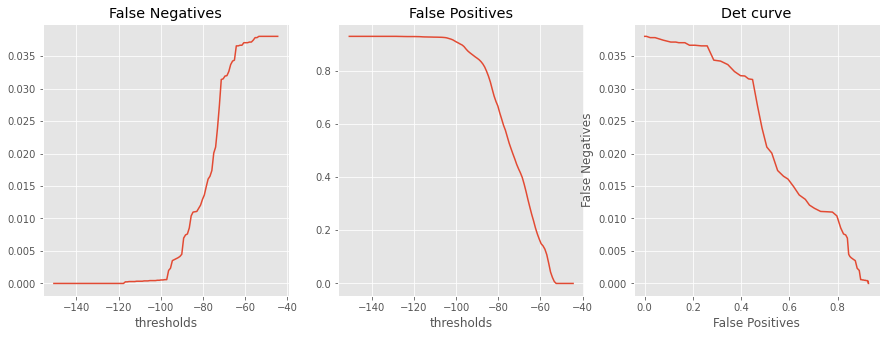

In [22]:
metrics.plot_errors_curve(
    cmodel.false_positives, cmodel.false_negatives, cmodel.thresholds, figsize=(15, 5)
)


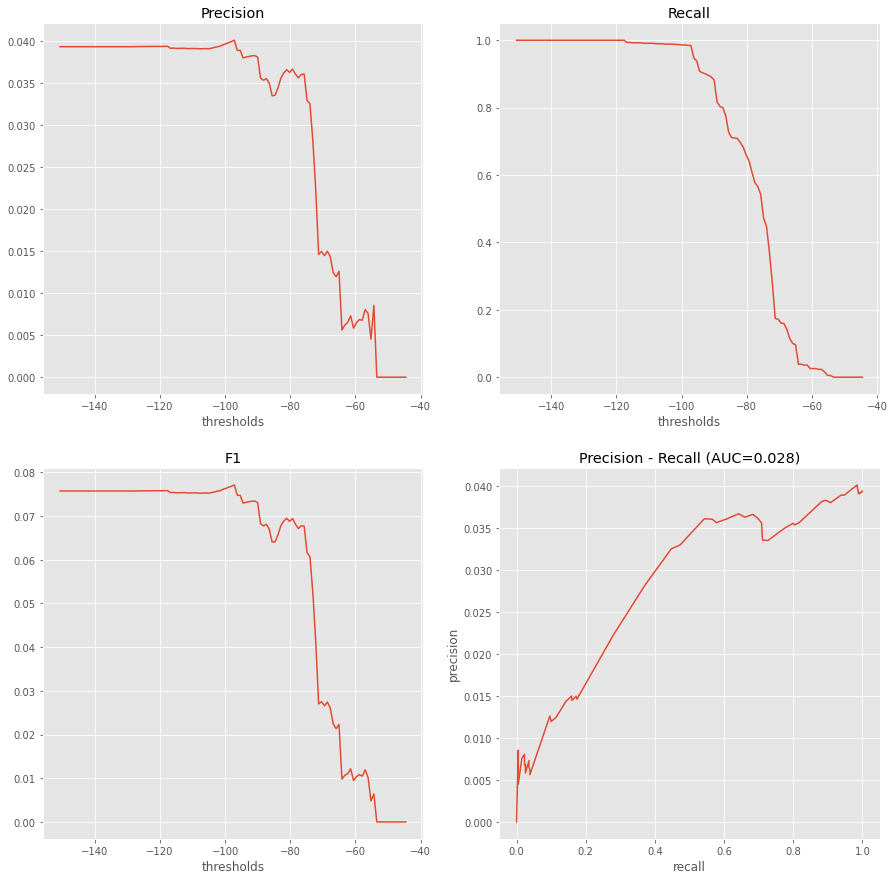

In [23]:
pr, rec, f1 = metrics.precision_recall_f1(
    cmodel.false_positives, cmodel.false_negatives
)
metrics.plot_precision_recall_f1_curve(pr, rec, f1, cmodel.thresholds)
